#<em> <font color='Brown'>Effects of El Niño and La Niña Events on Hurricane Formation and Landfalls in the US</font> </em>



<Center> <b>Authors</b></Center>
<Center><i><em>Bowen Han, Ruoming Han, Mohammed Aqid Khatkhatay, Simran Padam & Gabriel Weinstein</em></i></Center>
<Center><i> Columbia University</i></Center>









### **Abstract:**

<i>This project focuses on the effects of El Niño and La Niña conditions on Hurricanes on the east coast of the US. El Niño (La Niña) events are defined by 5 consecutive 3 month running (declining) mean sea surface temperature (SST) anomalies of greater than 0.5°C (smaller than -0.5°C) in the El Niño 3.4 region. El Niño and La Niña conditions affect hurricanes on the east coast of America by changing the meridional temperature gradient in the Atlantic. These conditions change the vertical windshear and either inhibit or enhance hurricane formation.  This data story is going to study what formation of hurricanes are affected by these events, including storm speed, hurricane location and landfall.</i>

## **Content:**

### 1. Packages and Libraries

### 2. Data Creation

### 3. Data Analysis

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 Differences Between the Distribution of Storm Speeds During El Niño (La Niña) Events and Under Normal Conditions

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 Locations of Hurricanes Affected by El Niño and La Niña Events

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 Categories of Hurricanes

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 Number of Hurricanes by Anomaly in Recent Years

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.5 Logistic Regression on the Probability of Landfall

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.6 Time Series Analysis on the Probability of Landfall

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.7 Clustering on the Moments of Hurricanes

#####&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.8 Clustering on Hurricane Starting Locations
### 4. Summary
### 5. GitHub and Contributors Statement

## **1. Packages and Libraries**

In [1]:
%%capture 
!pip install matplotlib 
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy 
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy --no-binary shapely --no-binary cartopy

In [2]:
#add all the libraries here 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
#import statsmodels as sm
from datetime import datetime

#for timeseries
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

#kmeans
from sklearn.preprocessing import StandardScaler #standardization
from sklearn.cluster import k_means # to perform k-means

#map projection
import cartopy.crs as ccrs # used for map projection
import cartopy.feature as cfeature # used for map projection


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **2. Data Creation**

In [3]:
%%capture
!wget https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.NA.list.v04r00.csv
!wget https://raw.githubusercontent.com/aqid98/ClimatePredictionChallenges/main/Data/Monthly%20Oceanic%20Nino%20Index%20\(ONI\)%20-%20Wide.csv

In [4]:
ibtracs_dataframe = pd.read_csv("/content/ibtracs.NA.list.v04r00.csv",sep=",",skiprows=[1],low_memory=False)
ibtracs_dataframe.head(3)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,...,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,,,,main,335,323,_____________O,,,,,,,,,-5,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,26.1000,-90.4000,TD,30,,,,,,,,,,,,6,291
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,,,,main,323,312,_____________P,,,,,,,,,-5,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,26.2001,-90.6999,TD,30,,,,,,,,,,,,6,290
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,,,,main,312,302,_____________O,,,,,,,,,-5,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,26.3000,-91.0000,TD,30,,,,,,,,,,,,6,290


In [5]:
## Helper Functions for Data Cleaning and Feature generation
def preprocess_ENSO(ENSO):
  """
  preprocess_ENSO creates a processed with the ENSO years

  :param ENSO: loaded raw ENSO dataframe
  :return: processed column names in the ENSO dataframe
  """
  ENSO = ENSO.iloc[0:,0:]
  ENSO.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']
  ENSO["Year"] = list(range(1950,2022))
  return ENSO

def get_ENSO_temperature_values(ENSO,year,month):
  """
  preprocess_ENSO creates a processed with the ENSO years

  :param ENSO: loaded raw ENSO dataframe
  :return: processed column names in the ENSO dataframe
  """ 
  return ENSO[ENSO.Year==year][month].values[0]

def get_ENSO_flag(t):
  """
  get_ENSO_flag returns integer value of Anamoly

  :param t: temperature value
  :return: integer -1,0 or 1
  """ 
  if t<=-0.5:
    return -1.0
  elif t>=0.5:
    return 1.0
  else:
    return 0.0

def get_hurricane_span_dict(df):
  """
  get_hurricane_span_dict creates a dictionary with the hurricane SID as key and Storm duration

  :param df: loaded raw ibtracs dataframe
  :return: dictionary with the hurricane SID as key and Storm duration
  """ 
  df_subset = df[['SID', 'DATE']]
  df_subset = df_subset.drop_duplicates(subset=['SID', 'DATE'], keep='first')
  df_subset = df_subset.groupby(['SID']).size().reset_index(name='Num_of_days_storm')
  sid2span = df_subset.set_index("SID").to_dict()["Num_of_days_storm"]
  return sid2span


def ibtracs_feature_generation(ibtracs,ENSO):
  """
  ibtracs_feature_generation adds additional features to the python dataframe.

  :param df: loaded raw ibtracs dataframe
  :return: processed ibtracs dataframe
  """
  ##Keeping only necessary columns for our data story
  ibtracs = ibtracs[['SID', 'SEASON', 'NAME', 'ISO_TIME', 'LAT', 'LON', 'WMO_WIND',
       'LANDFALL', 'DIST2LAND', 'STORM_SPEED', 'STORM_DIR', 'USA_SSHS']]
  month_dict = {"01":"Jan","02":"Feb","03":"Mar","04":"Apr","05":"May","06":"Jun","07":"Jul","08":"Aug","09":"Sep","10":"Oct","11":"Nov","12":"Dec"}
  ibtracs = ibtracs[ibtracs.SEASON>=1950]
  ibtracs["DATE"] = ibtracs.ISO_TIME.str[0:11]
  ibtracs["MONTH"] =  ibtracs.ISO_TIME.str[5:7].map(month_dict)
  ibtracs["TEMPERATURE"] = ibtracs[["SEASON","MONTH"]].apply(lambda x: get_ENSO_temperature_values(ENSO,x["SEASON"],x["MONTH"]),axis=1)
  ibtracs["ANAMOLY_FLAG"] = ibtracs["TEMPERATURE"].apply(get_ENSO_flag)
  ibtracs["ANAMOLY_CATEGORY"] = ibtracs["TEMPERATURE"].apply(lambda x: "El Nino" if x>=0.5 else ( "La Nina"  if x<=-0.5 else "Normal"))
  sid2span = get_hurricane_span_dict(ibtracs)
  ibtracs["SPAN"] = ibtracs.SID.map(sid2span)
  return ibtracs

def ibtracs_cleaning(ibtracs):
  """
  ibtracs_cleaning changes data types from object to float or int

  :param ibtracs: loaded raw ibtracs dataframe
  :return: processed ibtracs dataframe
  """
  ibtracs.WMO_WIND    = ibtracs.WMO_WIND.apply(lambda x: np.nan if x==" " else float(x))
  ibtracs.WMO_WIND    = ibtracs.WMO_WIND.astype(float)
  ibtracs.STORM_SPEED = ibtracs.STORM_SPEED.astype(int)
  ibtracs.STORM_DIR   = ibtracs.STORM_DIR.astype(int)
  ibtracs.LANDFALL    = ibtracs.LANDFALL.apply(lambda x: np.nan if x==" " else float(x))
  ibtracs.LANDFALL    = ibtracs.LANDFALL.astype(float)
  ibtracs.reset_index(inplace=True,drop=True)
  return ibtracs

def get_location_dataframe(df):
  """
  get_location_dataframe returns a location dataframe subset

  :param df: loaded raw df dataframe
  :return: processed dataframe subset
  """
  return df[['NAME','LAT','LON','STORM_SPEED','TEMPERATURE']].groupby('NAME').mean()

In [6]:
#Loading Monthly Oceanic Nino Index
ENSO_dataframe = pd.read_csv("/content/Monthly Oceanic Nino Index (ONI) - Wide.csv")

#Preprocessing ENSO
ENSO = preprocess_ENSO(ENSO_dataframe)

#Generate ibtracs features
ibtracs = ibtracs_feature_generation(ibtracs_dataframe,ENSO)

#Clean ibtracs Data
ibtracs = ibtracs_cleaning(ibtracs)

#Display
ibtracs

,SID,SEASON,NAME,ISO_TIME,LAT,LON,WMO_WIND,LANDFALL,DIST2LAND,STORM_SPEED,STORM_DIR,USA_SSHS,DATE,MONTH,TEMPERATURE,ANAMOLY_FLAG,ANAMOLY_CATEGORY,SPAN
0,1950224N17305,1950,ABLE,1950-08-12 00:00:00,17.1000,-55.5000,35.0,925.0,930,10,312,0,1950-08-12,Aug,-0.4,0.0,Normal,13
1,1950224N17305,1950,ABLE,1950-08-12 03:00:00,17.4176,-55.8722,NaN,926.0,930,10,308,0,1950-08-12,Aug,-0.4,0.0,Normal,13
2,1950224N17305,1950,ABLE,1950-08-12 06:00:00,17.7000,-56.3000,40.0,924.0,933,10,300,0,1950-08-12,Aug,-0.4,0.0,Normal,13
3,1950224N17305,1950,ABLE,1950-08-12 09:00:00,17.9350,-56.8204,NaN,866.0,924,12,296,0,1950-08-12,Aug,-0.4,0.0,Normal,13
4,1950224N17305,1950,ABLE,1950-08-12 12:00:00,18.2000,-57.4000,45.0,812.0,866,13,300,0,1950-08-12,Aug,-0.4,0.0,Normal,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61753,2021306N10279,2021,TERRY,2021-11-10 06:00:00,11.8000,-114.9000,NaN,1346.0,1346,13,267,-1,2021-11-10,Nov,-1.0,-1.0,La Nina,9
61754,2021306N10279,2021,TERRY,2021-11-10 09:00:00,11.7498,-115.5460,NaN,1382.0,1382,13,266,-1,2021-11-10,Nov,-1.0,-1.0,La Nina,9
61755,2021306N10279,2021,TERRY,2021-11-10 12:00:00,11.7000,-116.2000,NaN,1414.0,1414,13,267,-1,2021-11-10,Nov,-1.0,-1.0,La Nina,9
61756,2021306N10279,2021,TERRY,2021-11-10 15:00:00,11.6879,-116.8890,NaN,1450.0,1450,14,270,-1,2021-11-10,Nov,-1.0,-1.0,La Nina,9


## **3. Data analysis**

In order to understand how El Niño events impact hurricanes we focused on how different features of hurricanes (wind speed, probability of landfall, etc.) respond to El Niño conditions. We separate time into El Niño, La Niña, and normal conditions in order to perform our analysis. We start our analysis by evaluating wind speed and the number of hurricanes occurring during each of our three scenarios.

Note: Throughout this notebook temperature anomaly refers to the El Niño 3.4 temperature anomaly.

### 3.1 <font color='purple'>Differences Between the Distribution of Storm Speeds During El Niño (La Niña) Events and Under Normal Conditions </font> 


In this section, a Mann-Whitney U test is applied first to test if the distributions of storm speeds in various temperature conditions are different. Then, we find the effects of El Niño 3.4 temperature anomalies on storm speeds (3.1.2).

3.1.1 Mann-Whitney U test

In [7]:
speed_la_nina = pd.DataFrame({
    "la_nina" : ibtracs[ibtracs.ANAMOLY_CATEGORY=="La Nina"]["STORM_SPEED"].values
})
speed_normal = pd.DataFrame({
    "normal" : ibtracs[ibtracs.ANAMOLY_CATEGORY=="Normal"]["STORM_SPEED"].values
})
speed_el_nino = pd.DataFrame({
    "el_nino" : ibtracs[ibtracs.ANAMOLY_CATEGORY=="El Nino"]["STORM_SPEED"].values
})


def mann_whitney_u_test(distribution_1, distribution_2):
  """
  get_location_dataframe returns a location dataframe subset
  
  :param df: loaded raw df dataframe
  :return: processed dataframe subset
  """
  u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
  return u_statistic, p_value

result1=mann_whitney_u_test(list(ibtracs[ibtracs.ANAMOLY_CATEGORY=="El Nino"]["STORM_SPEED"]), 
                    list(ibtracs[ibtracs.ANAMOLY_CATEGORY=="Normal"]["STORM_SPEED"])
                    )
print(f"The p_value of U test for El_nino and Normal situation is {result1[1]}")

result2=mann_whitney_u_test(list(ibtracs[ibtracs.ANAMOLY_CATEGORY=="La Nina"]["STORM_SPEED"]), 
                    list(ibtracs[ibtracs.ANAMOLY_CATEGORY=="Normal"]["STORM_SPEED"])
                    )
print(f"The p_value of U test for La_nina and Normal situation is {result2[1]}")

The p_value of U test for El_nino and Normal situation is 2.0582583748505657e-06
The p_value of U test for La_nina and Normal situation is 1.089370754921696e-06


3.1.2 Plot the distributions of storm speed under Normal, El Niño or La Niña conditions

In [8]:
fig = go.Figure()
a_annotation = [{"x":40, "y":1000, 
                        "text": "<b> Fewer strong (measured in wind speed) storms <br> during El Niño and La Niña events <br> compared to normal conditions.</b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"#e1f5f1",
                        "font": {"size": 10}}]
fig.add_trace(go.Histogram(x=speed_normal["normal"].values, name="Normal",marker_color='#330C73'))
fig.add_trace(go.Histogram(x=speed_la_nina["la_nina"].values, name= "La Nina"))
fig.add_trace(go.Histogram(x=speed_el_nino["el_nino"].values, name= "El Nino"))
fig.update_layout(barmode='overlay',
                  title="Distribution of Storm Speed by Anomaly",
                  title_x=0.2,
                  xaxis_title="Storm Speed (knots)",
                  yaxis_title="Number of Hurricanes (units)",
                  width=951,
                  height=501,
                  annotations=a_annotation,
                legend=dict(orientation="h",yanchor='top',xanchor='center',y=-0.2,x=0.5))
fig.update_xaxes(range = [0,60])
fig.layout.plot_bgcolor = 'white'
fig.layout.paper_bgcolor = 'white'
fig.update_traces(opacity=1)
fig.show()

### *Insights:*

* The graph shows the speed of storms  distribution - majority of hurricanes lie below 20 Speed knots. Fewer strong (measured in wind speed) storms can be observed during El Niño or La Niña event as compared to normal event.

* The results of Mann-Whitney U test show that the p-values are extremely small for both El Niño and La Niña comparing with normal condition. So we can reject the null hypothesis H0: "The distribution of storm speeds during El Niño (La Niña) events are the same as the distribution of storm speeds in normal conditions", indicating that the distributions of storm speeds for El Niño and La Niña events are different from the distribution of storm speeds under normal conditions.

### 3.2 <font color='purple'> Locations of Hurricanes Affected by El Niño and La Niña Events </font>

We have already seen that El Niño 3.4 temperature anomalies have effects on storm speed. Therefore, it is reasonable to expect that the locations of hurricanes might be different during El Niño and La Niña events. In 3.2, we are going to force on the latitudes and longtitudes of hurricanes, and the mean values of them are chose to be the measurement.

In [9]:

location = get_location_dataframe(ibtracs)
location

,LAT,LON,STORM_SPEED,TEMPERATURE
NAME,,,,
ABBY,24.748997,-81.398701,8.989637,0.096891
ABLE,28.490624,-62.754297,12.873333,-0.026000
AGNES,26.996420,-83.658712,8.927536,0.900000
ALBERTO,32.543165,-63.666212,13.162996,-0.193833
ALEX,26.904387,-61.200160,15.177686,0.594628
...,...,...,...,...
VINCE,34.458493,-16.346350,10.037037,-0.300000
WANDA,37.917901,-50.875138,11.871560,-0.897248
WILFRED,12.715785,-34.952470,13.757576,-0.900000


In [10]:
fig = go.Figure()
fig.add_shape(
        type="rect",
        x0=-1.7,
        x1=-0.5,
        y0=10,
        y1=40,
        fillcolor="orange",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_shape(
        type="rect",
        x0=-0.5,
        x1=0.5,
        y0=10,
        y1=40,
        fillcolor="#CBC3E3",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_shape(
        type="rect",
        x0=+0.5,
        x1=1.5,
        y0=10,
        y1=40,
        fillcolor="LightSeaGreen",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_trace(go.Scatter(x=location.TEMPERATURE, y=location.LAT,
                    mode='markers',
                    line=dict(
                    color="LightSeaGreen",
                    width=1.5,
                    ),
            ))

a_annotation = [{"x":-1.1, "y":41, 
                        "text": "<b> La Nina</b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]

b_annotation = [{"x":0, "y":41, 
                        "text": "<b> Normal </b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]

c_annotation = [{"x":+1.1, "y":41, 
                        "text": "<b> El Nino</b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]                       
fig.update_layout(title="Plot of Temperature vs Latitude ",
                  annotations = a_annotation + b_annotation + c_annotation,
                  title_x=0.5,
                  xaxis_title="Temperature (ONI)",
                  yaxis_title="Latitude (°N)")
fig.update_xaxes(range = [-1.7,1.51])
fig.layout.plot_bgcolor = 'white'
fig.layout.paper_bgcolor = 'white'
fig.show()

In [11]:
fig = go.Figure()

fig.add_shape(
        type="rect",
        x0=-1.7,
        x1=-0.5,
        y0=-20,
        y1=-100,
        fillcolor="orange",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_shape(
        type="rect",
        x0=-0.5,
        x1=0.5,
        y0=-20,
        y1=-100,
        fillcolor="#CBC3E3",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_shape(
        type="rect",
        x0=+0.5,
        x1=1.5,
        y0=-20,
        y1=-100,
        fillcolor="LightSeaGreen",
        line=dict(
        color="LightSeaGreen",
        width=0,
    ),
        opacity=0.1,
    )
fig.add_trace(go.Scatter(x=location.TEMPERATURE, y=location.LON,
                    mode='markers',
                    line=dict(
                    color="LightSeaGreen",
                    width=1.5,
                    ),
            ))

a_annotation = [{"x":-1.1, "y":-18, 
                        "text": "<b> La Nina</b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]

b_annotation = [{"x":0, "y":-18, 
                        "text": "<b> Normal </b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]

c_annotation = [{"x":+1.1, "y":-18, 
                        "text": "<b> El Nino</b>",
                         "textangle": 0,
                        "showarrow":False,
                         "bgcolor":"white",
                        "font": {"size": 12}}]    

fig.update_layout(title="Plot of Temperature vs Longitude ",
                  annotations = a_annotation + b_annotation + c_annotation,
                  title_x=0.5,
                  xaxis_title="Temperature (ONI)",
                  yaxis_title="Longitude (°W)")
fig.update_xaxes(range = [-1.7,1.51])
fig.update_yaxes(range = [-100,-18])
fig.layout.plot_bgcolor = 'white'
fig.layout.paper_bgcolor = 'white'
fig.show()

### *Insights:*

* From these graphs we see that when temperature anomalies are close to zero (ie.in the normal situation), hurricanes mostly occur at 20-30 degrees north on the east side of North Amarica. When the value of the anomaly increases (El Niño situation) or decreases (La Niña situation), the hurricanes occur more widely from 10 degrees north to 40 degrees north, especially in the La Niña case. However, we do not see a clear pattern of how the longtitudes of hurricanes are affected by temperature anomalies.

* As a result, we can conclude that El Niño and La Niña conditions affect the locations of hurricanes. It is expected that when El Niño or La Niña events occur, the tracks of hurricanes are influenced strongly and are forced to move southward or northward from their original locations.


### 3.3 <font color='purple'> Categories of Hurricanes </font>

After gaining an understanding of how El Niño conditions affect hurricane locations we attempt to gain insight into how our three sets of conditions affect storm strength of more intense storms. Are La Niña conditions more favorable for the formation of stronger storms? What about El Niño?

In this section we will use data from USA SSHS (Saffir-Simpson Hurricane Wind Scale https://www.nhc.noaa.gov/aboutsshws.php) as the measurement of hurricane strength. Hurricanes in category 1 means "Very dangerous winds will produce some damage", hurricanes in category 2 means "Extremely dangerous winds will cause extensive damage", while categories 3-5 includes hurricanes with higher strength.

In [12]:
## Helper Functions
def get_sid_landfall(df):
  sid_landfall = set(df[df.LANDFALL==0.0].SID.values)
  return sid_landfall
def get_sid_max_cat(df,sid_landfall):
  sid2cat = {}
  for i in sid_landfall:
    sid2cat[i] = df[df.SID==i].USA_SSHS.max()
  return sid2cat
def get_subset_landfall(df,sid_landfall,sid2max_category):
  sid2season = df[df.SID.isin(sid_landfall)].set_index("SID").to_dict()["SEASON"]
  sid2anamoly = df[df.SID.isin(sid_landfall)].set_index("SID").to_dict()["ANAMOLY_CATEGORY"]
  df_ = df[df.SID.isin(sid_landfall)]
  df_subset = pd.DataFrame()
  df_subset["SID"] = list(sid_landfall)
  df_subset["HURRICANE_CATEGORY"] = df_subset["SID"].map(sid2max_category)
  df_subset["SEASON"] = df_subset["SID"].map(sid2season)
  df_subset["ANAMOLY_CATEGORY"] = df_subset["SID"].map(sid2anamoly)
  df_subset["HURRICANE_COUNT"] = 1
  return df_subset
def get_seasonwise(dfplot):
  start = dfplot.SEASON.min()
  end = dfplot.SEASON.max()
  season_map ={}
  for i in range(start,end):
    if len(season_map)==0:
      season_map[(i,-1)] = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY==-1)].SID.values))
      season_map[(i,0)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 0)].SID.values))
      season_map[(i,1)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 1)].SID.values))
      season_map[(i,2)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 2)].SID.values))
      season_map[(i,3)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 3)].SID.values))
      season_map[(i,4)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 4)].SID.values))
      season_map[(i,5)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 5)].SID.values))
    else:
      season_map[(i,-1)] = season_map[(i-1,-1)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY==-1)].SID.values))
      season_map[(i,0)]  = season_map[(i-1, 0)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 0)].SID.values))
      season_map[(i,1)]  = season_map[(i-1, 1)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 1)].SID.values))
      season_map[(i,2)]  = season_map[(i-1, 2)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 2)].SID.values))
      season_map[(i,3)]  = season_map[(i-1, 3)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 3)].SID.values))
      season_map[(i,4)]  = season_map[(i-1, 4)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 4)].SID.values))
      season_map[(i,5)]  = season_map[(i-1, 5)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 5)].SID.values))
  return season_map
def get_seasonwise_cat(dfplot):
  start = dfplot.SEASON.min()
  end = dfplot.SEASON.max()
  season_map ={}
  for i in range(start,end):
    if len(season_map)==0:
      season_map[(i,1)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 1)].SID.values))
      season_map[(i,2)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 2)].SID.values))
      season_map[(i,3)]  = len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY.isin([3,4,5]))].SID.values))
    else:
      season_map[(i,1)]  = season_map[(i-1, 1)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 1)].SID.values))
      season_map[(i,2)]  = season_map[(i-1, 2)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY== 2)].SID.values))
      season_map[(i,3)]  = season_map[(i-1, 3)] + len(set(dfplot[(dfplot.SEASON==i)&(dfplot.HURRICANE_CATEGORY.isin([3,4,5]))].SID.values))
  return season_map
def get_min_landfall(sid,df):
  storm_min_landfall = {}
  for storm in sid:
    min_landfall = df[df.SID==storm].LANDFALL.min()
    storm_min_landfall[storm] = min_landfall
  return storm_min_landfall
def generate_dataframe(df,min_landfall_dict,Anamoly):
  sid2season = df.set_index("SID").to_dict()["SEASON"]
  sid2name   = df.set_index("SID").to_dict()["NAME"]
  df_ = pd.DataFrame(min_landfall_dict.items(),columns=["SID","min_landfall"])
  df_["SEASON"] = df_.SID.map(sid2season)
  df_["NAME"]   = df_.SID.map(sid2name)
  df_["ANAMOLY"]   = Anamoly
  return df_
def generate_anamoly_df(df):
  Normal = df[df.ANAMOLY_CATEGORY=="Normal"][["SID","SEASON"]].groupby(["SEASON"]).agg("nunique").reset_index()
  Normal_years = set(Normal.SEASON.values)
  ElNino = df[df.ANAMOLY_CATEGORY=="El Nino"][["SID","SEASON"]].groupby(["SEASON"]).agg("nunique").reset_index()
  ElNino_years = set(ElNino.SEASON.values)
  LaNina = df[df.ANAMOLY_CATEGORY=="La Nina"][["SID","SEASON"]].groupby(["SEASON"]).agg("nunique").reset_index()
  LaNina_years = set(LaNina.SEASON.values)
  for i in range(1950,2022):
    if i not in ElNino_years:
      idx = len(ElNino)
      ElNino.at[idx,"SEASON"]=int(i)
      ElNino.at[idx,"SID"]= 0
    if i not in LaNina_years:
      idx = len(LaNina)
      LaNina.at[idx,"SEASON"]=int(i)
      LaNina.at[idx,"SID"]= 0
    if i not in Normal_years:
      idx = len(Normal)
      Normal.at[idx,"SEASON"]=int(i)
      Normal.at[idx,"SID"]= 0
  ElNino["SEASON"] = ElNino.SEASON.astype(int)
  ElNino = ElNino.sort_values("SEASON")
  ElNino.reset_index(inplace=True,drop=True)
  LaNina["SEASON"] = LaNina.SEASON.astype(int)
  LaNina=LaNina.sort_values("SEASON")
  LaNina.reset_index(inplace=True,drop=True)
  Normal["SEASON"] = Normal.SEASON.astype(int) 
  Normal = Normal.sort_values("SEASON")
  Normal.reset_index(inplace=True,drop=True)
  return Normal, ElNino, LaNina

def get_moving_average(df,window,Anamoly):
  COLUMN = str(window)+"_YRMA_"+Anamoly
  df[COLUMN] = 0
  df[COLUMN] = pd.Series.ewm(df['SID'],alpha=0.1).mean()
  return df

def generate_ewma(Normal, ElNino, LaNina):
  for j in [5,10,20]:
    ElNino = get_moving_average(ElNino,j,"El Nino")
    LaNina = get_moving_average(LaNina,j,"La Nina")
    Normal = get_moving_average(Normal,j,"Normal")
  Normal.rename(columns={"SID":"#Normal"},inplace=True)
  ElNino.rename(columns={"SID":"#ElNino"},inplace=True)
  LaNina.rename(columns={"SID":"#LaNina"},inplace=True)
  final=pd.DataFrame()
  final = pd.merge(Normal, ElNino, how="left",left_on=["SEASON"],right_on=["SEASON"])
  final = pd.merge(final, LaNina, how="left",left_on=["SEASON"],right_on=["SEASON"])
  return final

In [13]:
def plot_hurricane_trends_by_category(ibtracs,Cat):
  df= ibtracs[(ibtracs.USA_SSHS>=-1)&(ibtracs.ANAMOLY_CATEGORY==Cat)]
  if Cat=="Normal":
    y=[0.86,0.40,0.97]
    cnt=[44,17,46]
  elif Cat=="La Nina":
    y=[0.65,0.4,0.97]
    cnt=[28,15,45]
  else:
    y=[0.88,0.35,0.97]
    cnt=[18,6,19]
  dfplot = get_subset_landfall(df,get_sid_landfall(df),get_sid_max_cat(df,get_sid_landfall(df)))
  season_dict = get_seasonwise(dfplot)
  season_dict2 = get_seasonwise_cat(dfplot)
  season_df = pd.DataFrame(season_dict.items(), columns=['KEY', 'HURRICANES'])
  season_df['SEASON'], season_df['ANAMOLY_CATEGORY'] = zip(*season_df.KEY)
  season_df2 = pd.DataFrame(season_dict2.items(), columns=['KEY', 'HURRICANES'])
  season_df2['SEASON'], season_df2['ANAMOLY_CATEGORY'] = zip(*season_df2.KEY)
  fig = px.line(data_frame = season_df2,x = 'SEASON',y = 'HURRICANES',color="ANAMOLY_CATEGORY",line_group="ANAMOLY_CATEGORY",category_orders={'Level':[1,2,3]} ,color_discrete_map={1:'green',2:'orange',3:'red'})
  cat1_annotation = [
    {"xref":"paper", "yref":"paper", "x":1, "y":y[0],
                                "xanchor":"left", "yanchor":"top",
                                "text":'<b>💨 Category=1 ('+str(cnt[0])+')</b>',
                                "font":dict(family='Arial',
                                          size=12,
                                          color="green"),
                                "showarrow":False}]
  cat2_annotation = [
    {"xref":"paper", "yref":"paper", "x":1, "y":y[1],
                                "xanchor":"left", "yanchor":"top",
                                "text":'<b>🌪️ Category=2 ('+str(cnt[1])+')</b>',
                                "font":dict(family='Arial',
                                          size=12,
                                          color="orange"),
                                "showarrow":False}]

  cat3_annotation = [
    {"xref":"paper", "yref":"paper", "x":1, "y":y[2],
                                "xanchor":"left", "yanchor":"top",
                                "text":'<b>🌀🌧️ Major Hurricanes<br> with Category>=3 ('+str(cnt[2])+')</b>',
                                "font":dict(family='Arial',
                                          size=12,
                                          color="red"),
                                "showarrow":False}]


  fig.update_layout(title="Cumulative Distribution Hurricanes by Category "+str(Cat),
                    title_x=0.5,
                  showlegend=False,
                  width=800,
                  annotations=cat1_annotation+cat2_annotation+cat3_annotation,
                  margin={"l":50, "r":200},
                  yaxis_title="Cumulative Sum of Hurricanes",xaxis_title = "Year")
  fig.update_traces(patch={"line":{"color":"red", "width":5}}, 
                    selector={"legendgroup":"🌀🌧️"})

  fig.update_traces(patch={"line":{"color":"orange", "width":4}}, 
                    selector={"legendgroup":"💨"})
  fig.update_traces(patch={"line":{"color":"green", "width":3}}, 
                    selector={"legendgroup":"🌪️"})
  fig.layout.plot_bgcolor = 'white'
  fig.layout.paper_bgcolor = 'white'
  
  fig.show()

def plot_hurricane_trends_by_anamoly(ibtracs):
  df = ibtracs.copy()
  Normal_sids = set(df[df.ANAMOLY_CATEGORY=="Normal"].SID.values)
  LaNina_sids = set(df[df.ANAMOLY_CATEGORY=="La Nina"].SID.values)
  ElNino_sids = set(df[df.ANAMOLY_CATEGORY=="El Nino"].SID.values)
  el_nino_min_landfall = get_min_landfall(ElNino_sids,df)
  la_nina_min_landfall = get_min_landfall(LaNina_sids,df)
  normal_min_landfall  =  get_min_landfall(Normal_sids,df)
  elninoLF = generate_dataframe(df,el_nino_min_landfall,"EL NINO")
  laninaLF = generate_dataframe(df,la_nina_min_landfall,"LA NINA")
  NormalLF = generate_dataframe(df,normal_min_landfall,"NORMAL")
  df_landfall = pd.concat([elninoLF,laninaLF,NormalLF])
  df_landfall.reset_index(inplace=True,drop=True)
  fig = go.Figure()
  fig = px.histogram(df_landfall,
                        x="SEASON",
                        color="ANAMOLY",
                        barnorm = "percent",
                        text_auto= False,
                        opacity = 0.4,
                        color_discrete_sequence=["LightSeaGreen", "orange","#CBC3E3"],
                  ) \
          .update_layout (
                      title={
                              "text": "Stack Chart of Hurricanes by Anamoly",
                              "x": 0.5
                            },

                      yaxis_title="Number of Hurricanes",xaxis_title = "Year"
                  ) \
          .update_xaxes(categoryorder='total descending')
  fig.update_layout(bargap=0.1,legend=dict(orientation="h",yanchor='top',xanchor='center',y=-0.2,x=0.5))
  fig.update_yaxes(range = [0,100])

  
  fig.show()



def plot_hurricane_trends_by_temperature(ibtracs):
  Normal, ElNino, LaNina = generate_anamoly_df(ibtracs)
  final = generate_ewma(Normal, ElNino, LaNina)
  s = final[["SEASON","10_YRMA_Normal","10_YRMA_El Nino","10_YRMA_La Nina"]]
  random_x = s[s.SEASON>=1954].SEASON
  random_y0 = s[s.SEASON>=1954]["10_YRMA_Normal"]
  random_y1 = s[s.SEASON>=1954]["10_YRMA_El Nino"]
  random_y2 = s[s.SEASON>=1954]["10_YRMA_La Nina"]


  # Create traces
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=random_x, y=random_y0,
                      mode='lines+markers',
                      name='10 EWMA Normal',
                      line=dict(
                      color="mediumpurple",
                      width=1.5,
                      ),
              ))
  fig.add_trace(go.Scatter(x=random_x, y=random_y1,
                      mode='lines+markers',
                      name='10 EWMA El Nino',
                      line=dict(
                      color="LightSeaGreen",
                      width=1.5,
                      ),))
  fig.add_trace(go.Scatter(x=random_x, y=random_y2,
                      mode='lines+markers',
                      name='10 EWMA La Nina',
                      line=dict(
                      color="orange",
                      width=1.5,
                      ),))
  fig.add_shape(
          type="rect",
          x0=1977,
          x1=1998,
          y0=2,
          y1=15,
          fillcolor="#e1f5f1",
          line=dict(
          color="LightSeaGreen",
          width=0,
      ),
          opacity=0.4,
      )
  a_annotation = [{"x":1988, "y":14, 
                          "text": "<b>The most recent data suggests that we may be <br> heading into another period of time <br> similar to this span between 1977 and 1996</b>",
                          "textangle": 0,
                          "showarrow":False,
                          "bgcolor":"#e1f5f1",
                          "font": {"size": 11}}]
  fig.update_layout(title="10 Year EWMA of Number of Hurricanes by Anamoly",
                    title_x=0.5,
                  annotations=a_annotation,
                  legend=dict(orientation="h",yanchor='top',xanchor='center',y=-0.1,x=0.5))

  fig.layout.plot_bgcolor = 'white'
  fig.layout.paper_bgcolor = 'white'
  fig.show()


In [14]:
plot_hurricane_trends_by_category(ibtracs,'La Nina')

In [15]:
plot_hurricane_trends_by_category(ibtracs,'Normal')

In [16]:
plot_hurricane_trends_by_category(ibtracs,'El Nino')

# **Insights:**


*   There are fewer hurricanes overall and relatively fewer strong storms during El Niño events.

*   The percentage of high category hurricanes is higher during La Niña events than on normal condition.

*   In general, El Niño events are expected to decrease the strength of hurricanes while La Niña events will improve the strength.











### 3.4 <font color='purple'> Number of Hurricanes by Anomaly in Recent Years </font>

We are going to examine how many hurricanes occurred under different temperature conditions since 1950. We also wanted to see longer term trends in hurricane formation associated with our three scenarios. Are there long term changes in the number of hurricanes associated with El Niño and La Niña events? We attempt to answer this question in this section.

In [17]:
plot_hurricane_trends_by_anamoly(ibtracs)

In [18]:
plot_hurricane_trends_by_temperature(ibtracs)

### *Insights:*
Between 1977 and 1996 there are more storms corresponding to "normal" years compared to El Niño or La Niña years.

This is explained in two ways:

* There are only two years during this span of time that would be categorized as La Niña years. This does not allow much time for these events to have a substantial impact on hurricane formation during this time period. 

* There are El Niño and La Niña years in this span of time but we do not see many hurricanes associated with them. The overall trend of hurricanes related to El Niño and La Niña years does not vary much due to this span of time. 

Given the presence of El Niño events and their inverse correlation with hurricane formation, along with the lack of hurricane inducing La Niña years, it makes sense that most of the hurricanes occurring during this time period did not correlate with El Niño drivers.


### 3.5 <font color='purple'> Logistic Regression on the Probability of Landfall </font>


Up to this point, we have shown that El Niño 3.4 temperature anomalies affect the speed, location, and overall number of hurricanes in the Atlantic basin. In this section, the probability of landfall will be studied, and a regression between temperature anomaly and probability of landfall will be constructed.

In [19]:
def generate_logistic_regression_df(ibtracs):
  df = ibtracs.copy()
  df['ISO_TIME']=df['ISO_TIME'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  items=np.unique(df[['SID']].values)
  for item in items:
    min_index=df.loc[df.SID==item,'ISO_TIME'].idxmin() 
    df.loc[df.SID==item,'MIN_TIME']=df.loc[df.SID==item,'ISO_TIME'][min_index]

  #Only consider the temperature when the hurricane forms as variable
  items=np.unique(df[['SID']].values)
  new_array=np.array([df.loc[0].values])
  for item in items[1:]:
    min_index=df.loc[df.SID==item,'ISO_TIME'].idxmin()
    new_array=np.vstack([new_array,df.loc[min_index].values])
  new_data=pd.DataFrame(columns=['SID','SEASON','NAME','ISO_TIME',
                                 'LAT','LON','WMO_WIND','LANDFALL',
                                 'DIST2LAND','STORM_SPEED',
                                 'STORM_DIR','USA_SSHS','DATE','MONTH','TEMPERATURE',
                        'ANAMOLY_FLAG', 'ANAMOLY_CATEGORY','SPAN','MIN_TIME'],data=new_array)
  Normal_sids = set(df[df.ANAMOLY_CATEGORY=="Normal"].SID.values)
  LaNina_sids = set(df[df.ANAMOLY_CATEGORY=="La Nina"].SID.values)
  ElNino_sids = set(df[df.ANAMOLY_CATEGORY=="El Nino"].SID.values)
  el_nino_min_landfall = get_min_landfall(ElNino_sids,df)
  la_nina_min_landfall = get_min_landfall(LaNina_sids,df)
  normal_min_landfall  =  get_min_landfall(Normal_sids,df)
  elninoLF = generate_dataframe(df,el_nino_min_landfall,"EL NINO")
  laninaLF = generate_dataframe(df,la_nina_min_landfall,"LA NINA")
  NormalLF = generate_dataframe(df,normal_min_landfall,"NORMAL")
  df_landfall = pd.concat([elninoLF,laninaLF,NormalLF])
  df_landfall.reset_index(inplace=True,drop=True)
  df_landfall['IS_LANDFALL']   = df_landfall.min_landfall.apply(lambda x: 0 if x>0 else 1)
  dummmies=pd.get_dummies(df_landfall[['ANAMOLY']])
  df_landfall=pd.concat([df_landfall,dummmies],axis=1)
  df_landfall.rename(columns={"ANAMOLY_EL NINO": "El_Nino", "ANAMOLY_LA NINA": "La_Nina", 
                            "ANAMOLY_NORMAL":"Normal"},inplace=True)
  dataframe=pd.merge(new_data,df_landfall[['SID','IS_LANDFALL','El_Nino','La_Nina','Normal']],how='inner',on=['SID','SID'])
  dataframe=dataframe.dropna(how='any')
  dataframe['TEMPERATURE']=dataframe['TEMPERATURE'].astype('float')
  dataframe['STORM_SPEED']=dataframe['STORM_SPEED'].astype('float')
  return dataframe,new_data,df_landfall


In [20]:
LR_df,data_processed,df_landfall = generate_logistic_regression_df(ibtracs)
LR_df.head()

,SID,SEASON,NAME,ISO_TIME,LAT,LON,WMO_WIND,LANDFALL,DIST2LAND,STORM_SPEED,STORM_DIR,USA_SSHS,DATE,MONTH,TEMPERATURE,ANAMOLY_FLAG,ANAMOLY_CATEGORY,SPAN,MIN_TIME,IS_LANDFALL,El_Nino,La_Nina,Normal
0,1950224N17305,1950,ABLE,1950-08-12 00:00:00,17.1,-55.5,35.0,925.0,930,10.0,312,0,1950-08-12,Aug,-0.4,0.0,Normal,13,1950-08-12 00:00:00,1,0,0,1
1,1950231N12306,1950,BAKER,1950-08-18 12:00:00,12.0,-54.0,30.0,683.0,683,5.0,339,-1,1950-08-18,Aug,-0.4,0.0,Normal,15,1950-08-18 12:00:00,1,0,0,1
2,1950234N11334,1950,CHARLIE,1950-08-21 12:00:00,11.1,-26.4,35.0,1045.0,1045,12.0,265,0,1950-08-21,Aug,-0.4,0.0,Normal,16,1950-08-21 12:00:00,0,0,0,1
3,1950243N15304,1950,DOG,1950-08-30 18:00:00,15.2,-55.6,80.0,732.0,772,13.0,282,1,1950-08-30,Aug,-0.4,0.0,Normal,20,1950-08-30 18:00:00,1,0,0,1
4,1950244N20277,1950,EASY,1950-09-01 06:00:00,19.7,-83.2,40.0,183.0,194,2.0,0,0,1950-09-01,Sep,-0.4,0.0,Normal,9,1950-09-01 06:00:00,1,0,0,1


3.5.1.Regression of the Probability of the Landfall on Anomaly

In [21]:
logistic_model=sm.Logit(LR_df['IS_LANDFALL'],LR_df[['El_Nino','La_Nina']])
result1=logistic_model.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.689845
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1122
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                0.004437
Time:                        21:01:16   Log-Likelihood:                -775.39
converged:                       True   LL-Null:                       -778.84
Covariance Type:            nonrobust   LLR p-value:                  0.008564
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
El_Nino       -0.2029      0.123     -1.650      0.099      -0.444       0.038
La_Nina        0.2350      0.109      2.158      0.031       0.022       0.448
==============================================================================
"""

### *Insights:*

* We find that the p-value for the El Niño and La Niña situations is nearly 0, indicating that these two events are related to the probability of landfall. 


3.5.2 Regression of the Probability of Landfall on Temperature

In [22]:
logistic_model=sm.Logit(LR_df['IS_LANDFALL'],LR_df[['TEMPERATURE']])
result2=logistic_model.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.688475
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1123
Method:                           MLE   Df Model:                            0
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                0.006413
Time:                        21:01:16   Log-Likelihood:                -773.85
converged:                       True   LL-Null:                       -778.84
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TEMPERATURE    -0.2486      0.077     -3.218      0.001      -0.400      -0.097
===============================================================================
"""

### *Insights:*

* With these results, we can see that temperature anomaly also has a relationship with the probability of landfall as the p-values are less than the p-value above. We may think that temperature anomaly plays a bigger role on landfall compared with El Niño.

3.5.3 Regression of the Probability of Landfall on Temperature and Storm Speed

In [23]:
logistic_model=sm.Logit(LR_df['IS_LANDFALL'],LR_df[['TEMPERATURE','STORM_SPEED']])
result3=logistic_model.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.688036
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1124
Model:                          Logit   Df Residuals:                     1122
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                0.007048
Time:                        21:01:16   Log-Likelihood:                -773.35
converged:                       True   LL-Null:                       -778.84
Covariance Type:            nonrobust   LLR p-value:                 0.0009220
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
TEMPERATURE    -0.2535      0.078     -3.269      0.001      -0.405      -0.101
STORM_SPEED    -0.0051      0.005     -0.993      0.321      -0.015       0.005
===============================================================================
"""

### *Insights:*

* We find that storm speed does not have a clear relationship with the probability of landfall since its p-value is larger than 0.05 and its coefficent is nearly 0. 

### 3.6 <font color='purple'> Time Series Analysis on the Probability of Landfall </font>

To confirm that the probability of landfall is affected by temperature 

(-4.342020140766638, 0.00037539290679647233, 3, 67, {'1%': -3.5319549603840894, '5%': -2.905755128523123, '10%': -2.5903569458676765}, 754.2890907262428)
(array([0.5927035 , 1.21585607, 2.40298701]), array([0.44137559, 0.54447784, 0.49307883]))


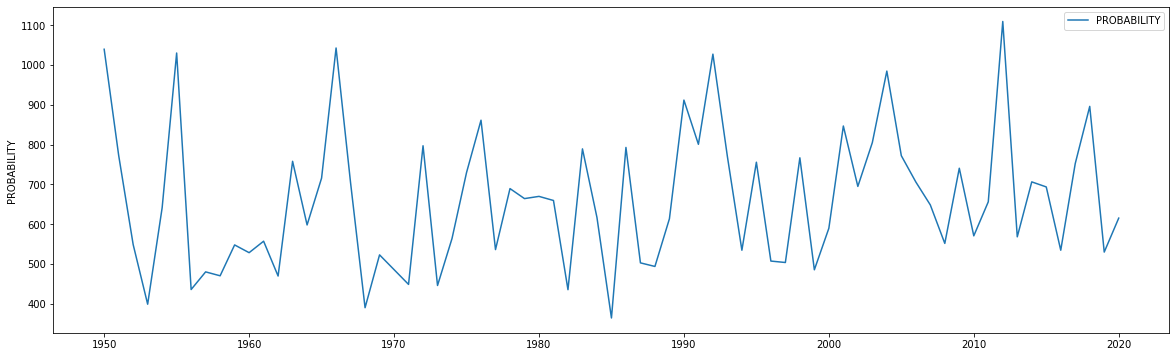

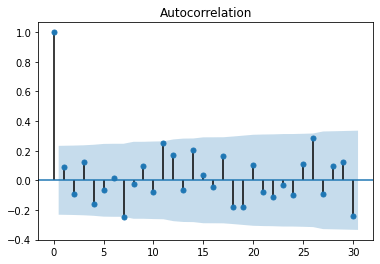

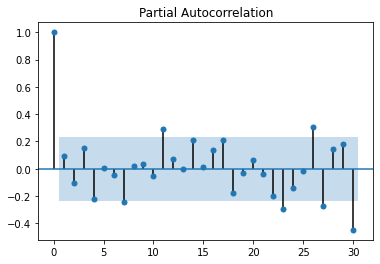

In [24]:
def plot_timeseries(ENSO,dataframe):
  a1=ENSO.iloc[:,1:].values.flatten().astype('float')
  index_list=[]
  for year in range(1950,2022,1):
    for month in range(1,13,1):
      index_list.append(datetime(year, month, 1, 0, 0))
  Temperature_map=pd.Series(index=index_list,data=a1,name='Tempature')
  Temperature_map=Temperature_map.dropna(axis=0, inplace=False, how=None)
  temperature_list=Temperature_map.cumsum()
  season_index=np.arange(1950,2021,1)
  time_series=pd.DataFrame(index=season_index,columns=['COUNT_LANDFALL','PROBABILITY','TEMPERATURE'])
  for year in season_index:
    time_series.loc[year,'COUNT_LANDFALL']=len(dataframe.loc[dataframe.SEASON==year,'LANDFALL'].index)
    time_series.loc[year,'PROBABILITY']=sum(dataframe.loc[dataframe.SEASON==year,'LANDFALL'])/len(dataframe.loc[dataframe.SEASON==year,'LANDFALL'].index)
    time_series.loc[year,'TEMPERATURE']=np.mean(temperature_list[(temperature_list.index>=datetime(year,5,1,0,0))&(temperature_list.index<datetime(year,12,1,0,0))])
    Ei_length=sum(dataframe[(dataframe.ISO_TIME>=datetime(year,5,1,0,0))&(dataframe.ISO_TIME<datetime(year,12,1,0,0))]['El_Nino'])
    La_length=sum(dataframe[(dataframe.ISO_TIME>=datetime(year,5,1,0,0))&(dataframe.ISO_TIME<datetime(year,12,1,0,0))]['La_Nina'])
    overall=len(dataframe[(dataframe.ISO_TIME>=datetime(year,5,1,0,0))&(dataframe.ISO_TIME<datetime(year,12,1,0,0))]['TEMPERATURE'])
    time_series.loc[year,'El_Nino']=Ei_length/overall
    time_series.loc[year,'La_Nina']=La_length/overall
  fig,ax=plt.subplots(1,1,figsize=(20,6))
  time_series[['PROBABILITY']].plot(ylabel='PROBABILITY',ax=ax)
  fig.show()
  series=time_series[['PROBABILITY']].dropna().values.flatten()
  series=[round(i,2) for i in series]
  dftest = adfuller(series, autolag='AIC')
  print(dftest)
  pacf= plot_acf(series,lags=30)
  acf = plot_pacf(series,lags=30)
  print(acorr_ljungbox(series,lags=3))
plot_timeseries(ENSO,LR_df)

### *Insights:*

* We find that the p-value is nearly 0, which means that the time series of probability is stationary whereas for the temperature anomaly it is non-stationary. From the acf and pacf plot we fail to get p and q so we choose to conduct the test to verify whether it is white noise. Then, we find that it has 98% confidence that this is white noise, so we conclude that time plays no role on the probability of landfall.  

### 3.7 <font color='purple'> Clustering on the Moments of Hurricanes </font>

In this section, we will identify five clusters based on the moments of hurricanes with different probabilities of landfall, spans and temperatures.

3.7.1 Find the clusters




In [25]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                      edgecolor='face', 
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face', 
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

def k_cluster(moment_lst):
  sum_of_squares = []
  K = range(1, 20)
  for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
  plt.plot(K, sum_of_squares, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Inertia Values against the Number of Cluster k')

def plot_kmeans(ibtracs):
  df = ibtracs.copy()
  SID_list=np.unique(df[['SID']].values)
  moment_list=np.empty((len(SID_list),5))
  for i in range(len(SID_list)):
    lat_list=df[df.SID==SID_list[i]].LAT
    lon_list=df[df.SID==SID_list[i]].LON
    df.loc[df.SID==SID_list[i],'mean_LON']=lon_list.mean()
    df.loc[df.SID==SID_list[i],'mean_LAT']=lat_list.mean()
    cv = np.ma.cov([lon_list, lat_list])
    df.loc[df.SID==SID_list[i],'var_LON']=cv[0,0]
    df.loc[df.SID==SID_list[i],'var_LAT']=cv[1,1]
    df.loc[df.SID==SID_list[i],'var_LONLAT']=cv[0,1]
    moment_list[i]=[lon_list.mean(),lat_list.mean(),cv[0,0],cv[1,1],cv[0,1]]
  k_cluster(moment_list)

def plot_standardised_cluster_info(ibtracs,data_processed,df_landfall):
  sid2land = df_landfall.set_index("SID").to_dict()["IS_LANDFALL"]
  df = ibtracs.copy()
  df['ISO_TIME']=df['ISO_TIME'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  df["IS_LANDFALL"] = df.SID.map(sid2land)
  SID_list=np.unique(df[['SID']].values)
  moment_list=np.empty((len(SID_list),5))
  time_list=data_processed.MIN_TIME.values
  for i in range(len(SID_list)):
    lat_list=df[df.SID==SID_list[i]].LAT
    lon_list=df[df.SID==SID_list[i]].LON
    df.loc[df.SID==SID_list[i],'mean_LON']=lon_list.mean()
    df.loc[df.SID==SID_list[i],'mean_LAT']=lat_list.mean()
    cv = np.ma.cov([lon_list, lat_list])
    df.loc[df.SID==SID_list[i],'var_LON']=cv[0,0]
    df.loc[df.SID==SID_list[i],'var_LAT']=cv[1,1]
    df.loc[df.SID==SID_list[i],'var_LONLAT']=cv[0,1]
    moment_list[i]=[lon_list.mean(),lat_list.mean(),cv[0,0],cv[1,1],cv[0,1]]
  scaler = StandardScaler().fit(moment_list)
  standardized_mon=scaler.transform(moment_list)
  km = k_means(standardized_mon,init='random',n_init=20,n_clusters=5,random_state=6)
  center=np.empty((5,5))
  for i in range(5):
    center[:,i]=km[0][:,i]*math.sqrt(scaler.var_[i])+scaler.mean_[i]
  centroid=pd.DataFrame(index=[str(i) for i in range(5)],columns=['Longitide','Latitude','Variance_lon','Variance_lat','Variance_lonlat']
                        ,data=center)
  for i in range(len(SID_list)):
    df.loc[df.SID==SID_list[i],'Cluster_location']=int(km[1][i])
  data = pd.DataFrame(index=df.index,columns = df.columns)
  for i in range(len(SID_list)):
    data.loc[i,]=df[(df.SID==SID_list[i])&(df.ISO_TIME==time_list[i])].values
  data=data.dropna(how='all')
  dummmies=pd.get_dummies(df[['ANAMOLY_CATEGORY']])
  data=pd.concat([data,dummmies],axis=1)
  data=data.rename(columns={"ANAMOLY_CATEGORY_El Nino": "El_Nino", "ANAMOLY_CATEGORY_La Nina": "La_Nina", 
                            "ANAMOLY_CATEGORY_Normal":"Normal" })
  items=['IS_LANDFALL','SPAN','TEMPERATURE','El_Nino','La_Nina','STORM_SPEED']
  for i in range(5):
    for item in items:
      centroid.loc[str(int(i)),item]=np.mean(data.loc[data.Cluster_location==i,item])
  fig,ax=plt.subplots(2,2,figsize=(25,10))
  var_list=[['IS_LANDFALL','SPAN'],['STORM_SPEED','TEMPERATURE']]
  for i in range(2):
    for j in range(2):
      centroid[[var_list[i][j]]].plot.bar(xlabel='cluster',ylabel=var_list[i][j],ax=ax[i][j],rot=0)
  plt.axhline(0)
  for i in range(5):
    lat=data[data.Cluster_location==i].LAT
    lon=data[data.Cluster_location==i].LON
    centroid.loc[str(int(i)),"P5_lat"],centroid.loc[str(int(i)),"P5_lon"]=np.percentile(lat, 5),np.percentile(lon, 5)
    centroid.loc[str(int(i)),"P95_lat"],centroid.loc[str(int(i)),"P95_lon"]=np.percentile(lat, 95),np.percentile(lon, 95)
    centroid.loc[str(int(i)),"Mean_lat"],centroid.loc[str(int(i)),"Mean_lon"]=np.mean(lat),np.mean(lon)
    centroid.loc[str(int(i)),"Median_lat"],centroid.loc[str(int(i)),"Median_lon"]=np.median(lat),np.median(lon)

  centroid[["P5_lat","P95_lat","Mean_lat","Median_lat","P5_lon","P95_lon","Mean_lon","Median_lon",'IS_LANDFALL','TEMPERATURE','El_Nino','La_Nina']]
  return data,centroid

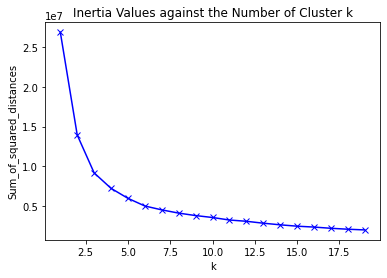

In [26]:
plot_kmeans(ibtracs)

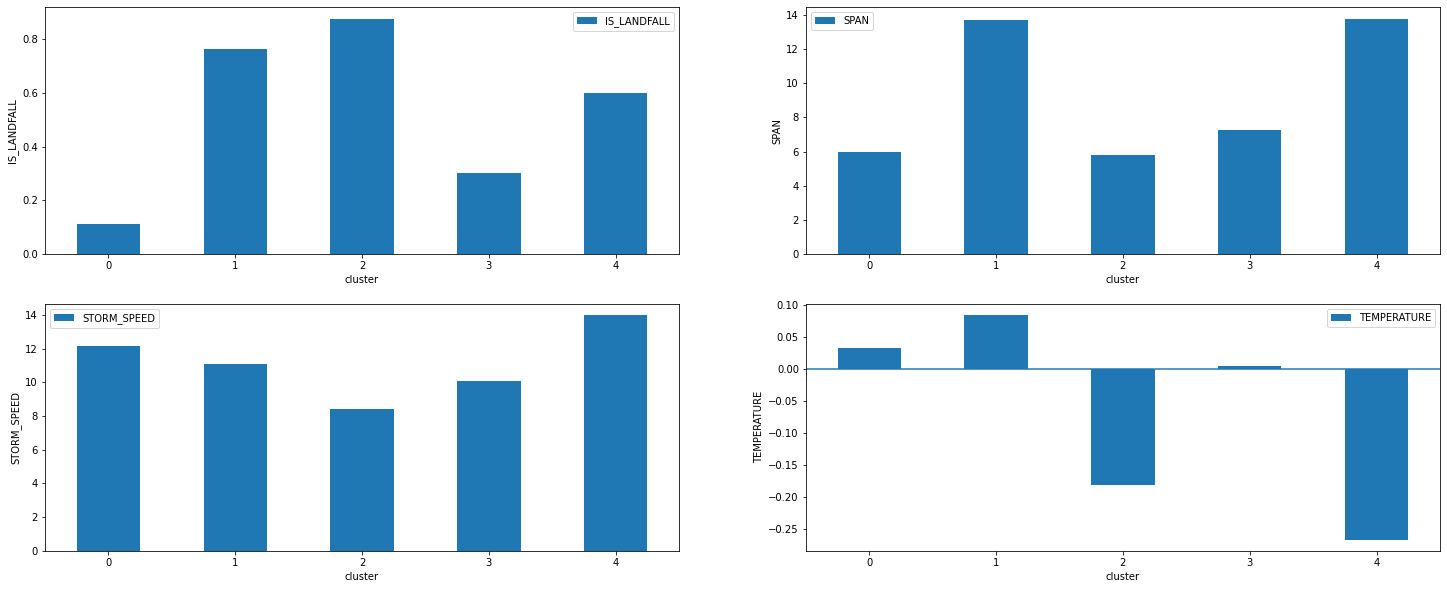

In [27]:
data,centroid = plot_standardised_cluster_info(ibtracs,data_processed,df_landfall)

### *Insights:*
From the plot we can see that each cluster has a different probability of landfall, span and temperature. The storm speed does not differ much. 

3.7.2 Regression on the clusters by moments

In [28]:
data=data.dropna(subset=['SID'])
reg_data=data[['IS_LANDFALL','Cluster_location','TEMPERATURE','El_Nino','La_Nina']]
reg_data=pd.concat([reg_data,pd.get_dummies(reg_data['Cluster_location'].astype('int'))],axis=1)
logistic_model=sm.Logit(reg_data[['IS_LANDFALL']].astype('float'),reg_data[[0,1,2,3,4]].astype('float'))
result4=logistic_model.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.489961
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1144
Model:                          Logit   Df Residuals:                     1139
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                  0.2929
Time:                        21:03:09   Log-Likelihood:                -560.52
converged:                       True   LL-Null:                       -792.71
Covariance Type:            nonrobust   LLR p-value:                 3.368e-99
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -2.0592      0.212     -9.696      0.000      -2.475      -1.643
1              1.1575      0.346      3.349      0.001       0.480       1.835
2              1.9339      0.154     12.524      0.000       1.631       2.237
3             -0.8353      0.115     -7.250      0.000      -1.061      -0.609
4              0.4055      0.173      2.350      0.019       0.067       0.744
==============================================================================
"""

### *Insights:*

* We can see that the cluster sort are also significant and they explain about 30 percent of the variation of landfalls.

3.7.3 Visualization Part of Clustering on Moments 

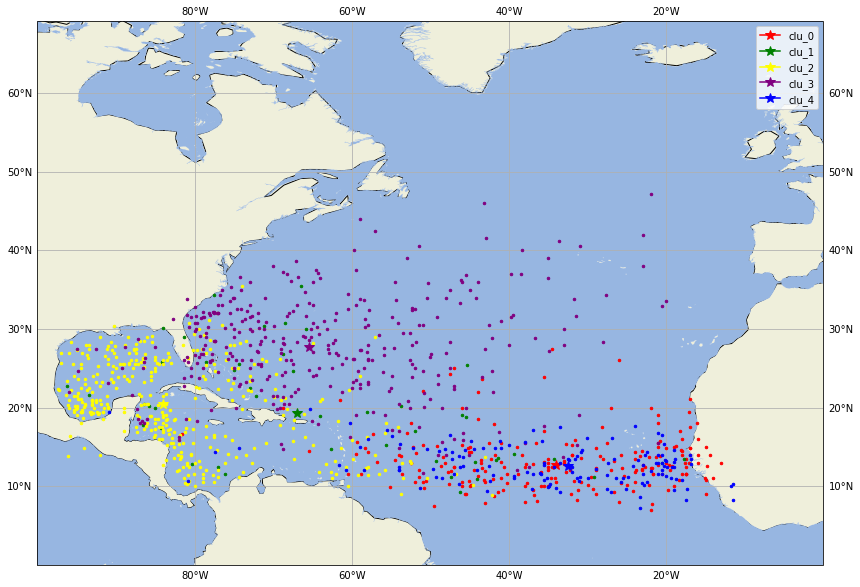

In [29]:
def plot_cluster_moments(centroid,data):
  a=centroid[["P5_lat","P95_lat","Mean_lat","Median_lat","P5_lon","P95_lon","Mean_lon","Median_lon",'IS_LANDFALL']]
  df0=data[data.Cluster_location==0][['LAT','LON']].values
  df1=data[data.Cluster_location==1][['LAT','LON']].values
  df2=data[data.Cluster_location==2][['LAT','LON']].values
  df3=data[data.Cluster_location==3][['LAT','LON']].values
  df4=data[data.Cluster_location==4][['LAT','LON']].values

  ax = map_background(extent=[-100, 0, 0, 60], label=True)
  colors=['red','green','yellow','purple','blue']
  labels=['clu_0','clu_1','clu_2','clu_3','clu_4']
  df_list=['df0','df1','df2','df3','df4']
  for i in range(5):
    variable=eval(df_list[i])
    P5_lon,P95_lon=a.loc[str(int(i)),'P5_lon'],a.loc[str(int(0)),'P95_lon']
    P5_lat,P95_lat=a.loc[str(int(i)),'P5_lat'],a.loc[str(int(0)),'P95_lat']
    ax.plot(a.loc[str(int(i)),'Median_lon'],a.loc[str(int(i)),'Median_lat'],color=colors[i],marker='*',markersize=10,label=labels[i])
    for j in range(len(variable)):
      ax.plot(variable[j,1],variable[j,0],color=colors[i],marker='.',markersize=5)
  ax.legend()
plot_cluster_moments(centroid,data)

### *Insights:*
* From the plot, we find that cluster_2 concentrates on the Gulf of Mexico, which is near land, and thus, hurricanes in this cluster have a high probability of landfall. In comparison, the points in cluster_3 all concentrate on the Atlantic, which is far from any land, resulting in lower probability of landfall. 
* What we find interesting is that cluster 0 and cluster 4 are located in the same area (between 10N to 20N and -60W to -20W), but have different probabilities of landfall. The main difference between the two clusters is their different El Niño 3.4 temperature anomalies. The temperature anomalies of  cluster 4 are negative, which may lead to a higher probability of landfall.In addition, cluster 4 has a higher occurance of La Niña conditions and a lower occurance of El Niño conditions.  

3.7.4 Analysis of cluster 0 and cluster 4

In [30]:
table  = centroid.loc[['0','4'],["P5_lat","P95_lat","Mean_lat","Median_lat","P5_lon","P95_lon","Mean_lon","Median_lon",'IS_LANDFALL','TEMPERATURE','El_Nino','La_Nina']]
for i in table.columns:
  table[i] = table[i].apply(lambda x: round(x,2))
table.reset_index(inplace=True)
table.rename(columns={'IS_LANDFALL':"Probability of Landfall", 'TEMPERATURE':"Temperature", 'El_Nino':"El Nino",
       'La_Nina':"La Nina","index":"Cluster Id"},inplace=True)

table[['Cluster Id','Probability of Landfall', 'Temperature',
       'El Nino', 'La Nina','P5_lat', 'P95_lat', 'Mean_lat', 'Median_lat', 'P5_lon', 'P95_lon',
       'Mean_lon', 'Median_lon']]

,Cluster Id,Probability of Landfall,Temperature,El Nino,La Nina,P5_lat,P95_lat,Mean_lat,Median_lat,P5_lon,P95_lon,Mean_lon,Median_lon
0,0,0.11,0.03,0.0,0.07,9.0,20.00,13.24,12.70,-56.80,-16.1,-34.31,-34.00
1,4,0.60,-0.27,0.0,0.15,9.5,16.81,12.75,12.55,-60.23,-17.5,-34.87,-32.45


In [31]:
centroid.loc[['0','4'],["P5_lat","P95_lat","Mean_lat","Median_lat","P5_lon","P95_lon","Mean_lon","Median_lon",'IS_LANDFALL']]

zero=data[data.Cluster_location==0]
four=data[data.Cluster_location==4]

zero_=zero[['Cluster_location','El_Nino','La_Nina','TEMPERATURE','IS_LANDFALL']]
four_=four[['Cluster_location','El_Nino','La_Nina','TEMPERATURE','IS_LANDFALL']]

result=pd.DataFrame(index=['clu_0','clu_4'],columns=['Anamoly','TEMPERATURE'],data=np.empty((2,2)))

zero_ano=result1.predict(zero_[['El_Nino','La_Nina']]).apply(lambda x: 0 if x<=0.5 else 1)
zero_temp=result2.predict(zero_[['TEMPERATURE']].astype('float')).apply(lambda x: 0 if x<=0.5 else 1)
four_ano=result1.predict(four_[['El_Nino','La_Nina']]).apply(lambda x: 0 if x<=0.5 else 1)
four_temp=result2.predict(four_[['TEMPERATURE']].astype('float')).apply(lambda x: 0 if x<=0.5 else 1)

accuracy=[]
accuracy.append(np.mean([i==j for i,j in zip(zero_ano.values,zero_[['IS_LANDFALL']].values)]))
accuracy.append(np.mean([i==j for i,j in zip(zero_temp.values,zero_[['IS_LANDFALL']].values)]))
accuracy.append(np.mean([i==j for i,j in zip(four_ano.values,four_[['IS_LANDFALL']].values)]))
accuracy.append(np.mean([i==j for i,j in zip(four_temp.values,four_[['IS_LANDFALL']].values)]))
result.loc['clu_0','Anamoly']=accuracy[0]
result.loc['clu_0','TEMPERATURE']=accuracy[1]
result.loc['clu_4','Anamoly']=accuracy[2]
result.loc['clu_4','TEMPERATURE']=accuracy[3]

print("The accuracy of using the anamoly or temperature to predict the landfall: ")
result

The accuracy of using the anamoly or temperature to predict the landfall: 


,Anamoly,TEMPERATURE
clu_0,0.841629,0.493213
clu_4,0.464286,0.585714


### *Insights:*

* We can see that the accuracy of using the El Niño 3.4 temperature anomaly to predict landfalls is not high. This means that the temperature anomaly is not the only difference between the two clusters. 




### 3.8 <font color='purple'> Clustering on Hurricane Starting Locations </font>

Now we are going to get clusters from the starting points of hurricanes.

In [32]:
def cluster_on_origin_location(ibtracs,data,centroid,df_landfall):
  sid2land = df_landfall.set_index("SID").to_dict()["IS_LANDFALL"]
  df = ibtracs.copy()
  df['ISO_TIME']=df['ISO_TIME'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  df["IS_LANDFALL"] = df.SID.map(sid2land)
  SID_list=np.unique(df[['SID']].values)
  mom_list=data[['LAT','LON']].values
  scaler = StandardScaler().fit(mom_list)
  standardized_mon=scaler.transform(mom_list)
  km = k_means(standardized_mon,init='random',n_init=20,n_clusters=5,random_state=6)
  center=np.empty((5,2))
  for i in range(2):
    center[:,i]=km[0][:,i]*math.sqrt(scaler.var_[i])+scaler.mean_[i]
  centroid=pd.DataFrame(index=[str(i) for i in range(5)],columns=['Longitide','Latitude']
                        ,data=center)
  for i in range(len(SID_list)):
    data.loc[data.SID==SID_list[i],'Cluster_origin']=int(km[1][i])
  time_list=data_processed.MIN_TIME.values
  data_origin=data[['SPAN','IS_LANDFALL','El_Nino','La_Nina','Cluster_origin','TEMPERATURE']]
  items=['SPAN','IS_LANDFALL','TEMPERATURE','El_Nino','La_Nina','STORM_SPEED']
  for i in range(5):
    for item in items:
      centroid.loc[str(int(i)),item]=np.mean(data.loc[data.Cluster_origin==i,item])
  a=centroid[["Longitide","Latitude"]]
  df0=data[data.Cluster_origin==0][['LAT','LON']].values
  df1=data[data.Cluster_origin==1][['LAT','LON']].values
  df2=data[data.Cluster_origin==2][['LAT','LON']].values
  df3=data[data.Cluster_origin==3][['LAT','LON']].values
  df4=data[data.Cluster_origin==4][['LAT','LON']].values
  ax = map_background(extent=[-100, 0, 0, 60], label=True)
  colors=['red','green','yellow','purple','blue']
  labels=['clu_0','clu_1','clu_2','clu_3','clu_4']
  df_list=['df0','df1','df2','df3','df4']
  for i in range(5):
    variable=eval(df_list[i])
    ax.plot(a.loc[str(int(i)),'Longitide'],a.loc[str(int(i)),'Latitude'],color=colors[i],marker='*',markersize=10,label=labels[i])
    for j in range(len(variable)):
      ax.plot(variable[j,1],variable[j,0],color=colors[i],marker='.',markersize=5)
  ax.text(
    -50, 35, "Cluster 0 (Low Landfall)", ha="center", va="center", rotation=0, size=12)
  ax.text(
    -80, 25, "Cluster 1,2,4 (High Landfall)", ha="center", va="center", rotation=0, size=12)
  ax.text(
    -27, 21, "Cluster 3 (Low Landfall)", ha="center", va="center", rotation=0, size=12)
  ax.legend()
  return data_origin

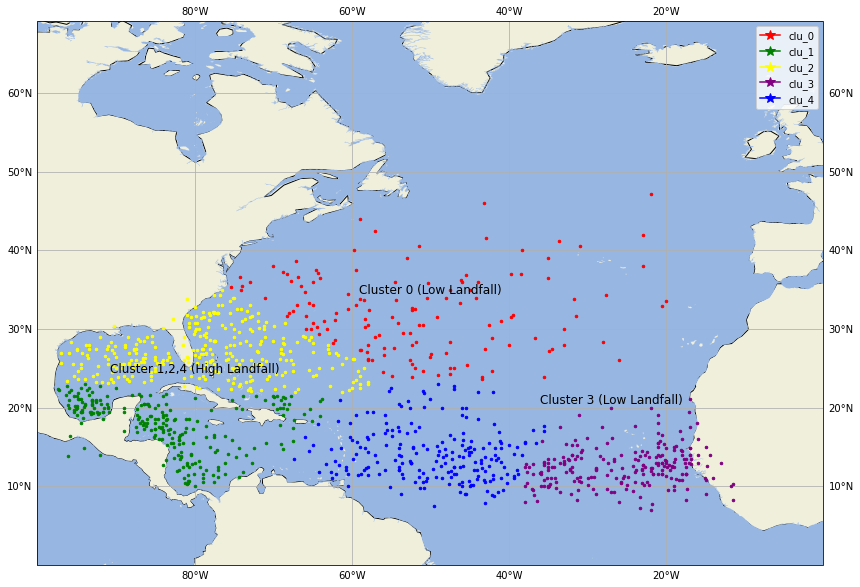

In [33]:
data_origin=cluster_on_origin_location(ibtracs,data,centroid,df_landfall)

### *Insights:*
* We find that when we form clusters based on the start points, cluster 0 concentrates on the East Atlantic, clusters 1 and 2 concentrate on the Gulf of Mexico, cluster 3 concentrates near West Africa, and cluster 4 concentrates Northeast of South America. While Cluster 1, 2 and 4 have high probabilities of landfall, clusters 0 and 3 have low probabilities of landfall. 

In [34]:
reg_data=data_origin[['IS_LANDFALL','Cluster_origin','TEMPERATURE']]
reg_data=pd.concat([reg_data,pd.get_dummies(reg_data['Cluster_origin'].astype('int'))],axis=1)
logistic_model=sm.Logit(reg_data[['IS_LANDFALL']].astype('float'),reg_data[[0,1,2,3,4]].astype('float'))
result5=logistic_model.fit()
result5.summary()


Optimization terminated successfully.
         Current function value: 0.553047
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1144
Model:                          Logit   Df Residuals:                     1139
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                  0.2019
Time:                        21:03:33   Log-Likelihood:                -632.69
converged:                       True   LL-Null:                       -792.71
Covariance Type:            nonrobust   LLR p-value:                 5.128e-68
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -1.9054      0.253     -7.542      0.000      -2.401      -1.410
1              2.0172      0.198     10.205      0.000       1.630       2.405
2              0.4721      0.116      4.075      0.000       0.245       0.699
3             -0.9909      0.149     -6.663      0.000      -1.282      -0.699
4             -0.2822      0.138     -2.044      0.041      -0.553      -0.012
==============================================================================
"""

In [35]:
reg_data=data_origin[['IS_LANDFALL','Cluster_origin','TEMPERATURE']]
reg_data=pd.concat([reg_data,pd.get_dummies(reg_data['Cluster_origin'].astype('int'))],axis=1)
logistic_model=sm.Logit(reg_data[['IS_LANDFALL']].astype('float'),reg_data[[0,1,2,3,4,'TEMPERATURE']].astype('float'))
result6=logistic_model.fit()
result6.summary()

Optimization terminated successfully.
         Current function value: 0.550892
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            IS_LANDFALL   No. Observations:                 1144
Model:                          Logit   Df Residuals:                     1138
Method:                           MLE   Df Model:                            5
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:                  0.2050
Time:                        21:03:33   Log-Likelihood:                -630.22
converged:                       True   LL-Null:                       -792.71
Covariance Type:            nonrobust   LLR p-value:                 4.253e-68
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
0              -1.9230      0.253     -7.592      0.000      -2.419      -1.427
1               1.9741      0.199      9.945      0.000       1.585       2.363
2               0.4784      0.116      4.116      0.000       0.251       0.706
3              -1.0139      0.150     -6.777      0.000      -1.307      -0.721
4              -0.2925      0.139     -2.111      0.035      -0.564      -0.021
TEMPERATURE    -0.1989      0.090     -2.211      0.027      -0.375      -0.023
===============================================================================
"""

### *Insights:*
* The origin point of hurricanes and El Niño 3.4 temperature anomalies both significantly impact the probability of the landfall. This is supported by a p-value of nearly 0. 

## **4. Summary**

1. The El Niño 3.4 temperature anomaly has a significant effect on the storm speeds of hurricanes. Hurricanes during El Niño and La Niña events tend to have lower speeds than during normal conditions.

2. While the center points of tracks of hurricanes under normal conditions centralize between 20-30 degrees north, El Niño and La Niña conditions widen this span to between 10 degrees north and 40 degrees north. As a result, El Niño and La Niña events affect the tracks of hurricanes significantly.

3. El Niño events are expected to decrease the strength of hurricanes while La Niña events will improve the strength.

4. El Niño 3.4 Temperature anomalies have a negative effect on the probability of landfall. In other words, the probability of landfall of hurricanes during El Niño events is lower than the probability during normal years, while a higher probability of landfall is evident during La Niña events.

## **5. GitHub and Contributors Statement**

This project can be found at the following repository. 
https://github.com/aqid98/ClimatePredictionChallenges

<b>Contribution statement:</b>
<br>
All team members contributed equally in all stages of this project. All team members approve our work presented in this GitHub repository including this contributions statement.